In [1]:
import pyspark
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder\
                    .master("yarn")\
                    .appName("tp3")\
                    .config('spark.ui.port', '4075')\
                    .config('spark.executor.memory', '4g')\
                    .config('spark.executor.cores', '2')\
                    .config('spark.executor.instances', '4')\
                    .config('spark.driver.memory', '4g')\
                    .config('spark.driver.maxResultSize', '2g')\
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-02-20 23:31:14,790 WARN spark.SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
df_spark = spark.read.json("/datasets/imdb/", multiLine=True)

In [4]:
df_spark.show()

[Stage 1:>                                                          (0 + 1) / 1]

+--------+--------------------+------+-----------------+--------------------+---------+--------------------+----------------+-----------+
| helpful|               movie|rating|      review_date|       review_detail|review_id|      review_summary|        reviewer|spoiler_tag|
+--------+--------------------+------+-----------------+--------------------+---------+--------------------+----------------+-----------+
|  [1, 3]|Dead Man on Campu...|    10| 13 December 2001|I didn't even see...|rw0400504|A very funny, and...|  kevgtchlk4life|          0|
|  [2, 2]|Dead Man on Campu...|  null|  22 January 1999|It's definitely n...|rw0400505|Fun if you don't ...|        DaniXand|          0|
|  [1, 3]|Dead Man on Campu...|  null|   9 January 2002|First of all can ...|rw0400506|This is the way c...|     ted_the_bad|          0|
|  [1, 3]|Dead Man on Campu...|  null|       1 May 2002|My friend was ALW...|rw0400508|Although I didn't...|        Kmk12277|          0|
|  [2, 3]|Dead Man on Campu...|  n

Qual ano teve filmes mais bem avaliados?

- Aqui vamos agrupar os filmes pelo ano de lançamento e analisar a média de notas por ano. Assim, é possível dizer qual ano lançou filmes mais bem avaliados.

In [4]:
from pyspark.sql.functions import col

df1 = df_spark.select(col("movie"),col("rating"))

In [6]:
df1 = df1.dropna()

In [5]:
from pyspark.sql.functions import regexp_replace, regexp_extract

result = df1.withColumn('ano', regexp_extract(col('movie'),  r"\(([^()]+)\)$", 1))

In [6]:
import pyspark.sql.functions as F

result = result.withColumn('n_digitos', F.length('ano'))

In [7]:
anos_df = result.filter(result.n_digitos == '4')

In [8]:
from pyspark.sql.types import IntegerType
anos_df = anos_df.withColumn("rating", anos_df["rating"].cast(IntegerType()))

In [11]:
anos_df.agg({'rating': 'mean'}).show()

[Stage 2:============================================>              (3 + 1) / 4]

+-----------------+
|      avg(rating)|
+-----------------+
|6.637849016158676|
+-----------------+



In [12]:
anos_df.agg({'rating': 'stddev'}).show()

[Stage 4:============================================>              (3 + 1) / 4]

+-----------------+
|   stddev(rating)|
+-----------------+
|2.966792018206405|
+-----------------+



In [13]:
anos_df = anos_df.withColumn("normal", (anos_df["rating"]-6.637849016158676)/2.966792018206405)

In [14]:
anos_df = anos_df.groupBy("ano").mean("normal") 

In [15]:
anos_df.orderBy(col("avg(normal)").desc()).show()

[Stage 7:====================================>                 (137 + 10) / 200]

+----+-------------------+
| ano|        avg(normal)|
+----+-------------------+
|2022|  1.133261436328771|
|1888| 0.5084591161088291|
|1994| 0.4368802838822254|
|1928|0.30351001460408844|
|1927|0.29138428306791075|
|1887| 0.2776363965943769|
|1925|0.26799094324909517|
|1922| 0.2615880985629015|
|1993| 0.2530994920693304|
|1924|0.24703426416932733|
|1946|0.24510046498931853|
|1920|0.23589651636490958|
|1926| 0.2350957940018852|
|1995|0.23305251085781029|
|1962|0.22987601479735245|
|1960| 0.2286105753194348|
|1954|0.22574391780558328|
|1939|0.22312394260004992|
|1950|0.22302115136549097|
|1948| 0.2229656077589266|
+----+-------------------+
only showing top 20 rows



Uso da plataforma ao longo dos anos.

- Aqui analisamos a quantidade de usuários ativos na plataforma ao longo dos anos;
- Analisamos também o número de reviews - ao longo dos anos;

In [16]:
df2 = df_spark.select(col("review_id"),col("reviewer"),col("review_date"))

In [17]:
df2= df2.withColumn("ano", regexp_extract("review_date", "(\\d{4})" , 1))

In [18]:
#reviews = 
df2.groupBy("ano").count().show(truncate=False)

+----+------+
|ano |count |
+----+------+
|2016|146394|
|2020|912362|
|2012|49853 |
|2019|695413|
|2017|126893|
|2014|104345|
|2013|186795|
|2005|87054 |
|2000|53550 |
|2002|55697 |
|2009|39548 |
|2018|456122|
|2006|129593|
|2004|107834|
|2011|148673|
|2008|157339|
|1999|67488 |
|2007|31700 |
|2021|32741 |
|2015|197402|
+----+------+
only showing top 20 rows



In [254]:
anosr = [1999,2000, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
reviewsn = [67488,53550,55697,107834,87054,128593,31700,157339,38548,148673, 49853,186795,104345,197402,146394,126893,456122,695413,912362]

In [ ]:
import matplotlib.pyplot as plt

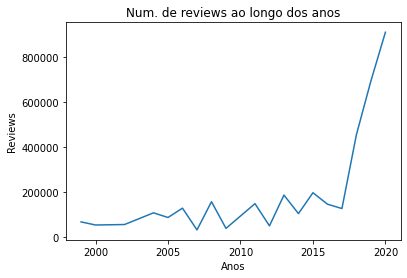

In [255]:
plt.plot(anosr, reviewsn)
 
plt.xlabel('Anos')
plt.ylabel('Reviews')
plt.title('Num. de reviews ao longo dos anos')
plt.show()

In [19]:
#users em 1999
users1 = df2.filter(df2.ano == '1999')
users1 = users1.dropDuplicates(["reviewer"])
users1 = users1.groupBy("ano").count()

#users em 2000
users2 = df2.filter(df2.ano == '2000')
users2 = users2.dropDuplicates(["reviewer"])
users2 = users2.groupBy("ano").count()

#users em 2001
users3 = df2.filter(df2.ano == '2001')
users3 = users3.dropDuplicates(["reviewer"])
users3 = users3.groupBy("ano").count()

#users em 2002
users4 = df2.filter(df2.ano == '2002')
users4 = users4.dropDuplicates(["reviewer"])
users4 = users4.groupBy("ano").count()

#users em 2003
users5 = df2.filter(df2.ano == '2003')
users5 = users5.dropDuplicates(["reviewer"])
users5 = users5.groupBy("ano").count()

#users em 2004
users6 = df2.filter(df2.ano == '2004')
users6 = users6.dropDuplicates(["reviewer"])
users6 = users6.groupBy("ano").count()

#users em 2005
users7 = df2.filter(df2.ano == '2005')
users7 = users7.dropDuplicates(["reviewer"])
users7 = users7.groupBy("ano").count()

#users em 2006
users8 = df2.filter(df2.ano == '2006')
users8 = users8.dropDuplicates(["reviewer"])
users8 = users8.groupBy("ano").count()

#users em 2007
users9 = df2.filter(df2.ano == '2007')
users9 = users9.dropDuplicates(["reviewer"])
users9 = users9.groupBy("ano").count()

#users em 2008
users10 = df2.filter(df2.ano == '2008')
users10 = users10.dropDuplicates(["reviewer"])
users10 = users10.groupBy("ano").count()

#users em 2009
users11 = df2.filter(df2.ano == '2009')
users11 = users11.dropDuplicates(["reviewer"])
users11 = users11.groupBy("ano").count()

#users em 2010
users12 = df2.filter(df2.ano == '2010')
users12 = users12.dropDuplicates(["reviewer"])
users12 = users12.groupBy("ano").count()

#users em 2011
users13 = df2.filter(df2.ano == '2011')
users13 = users13.dropDuplicates(["reviewer"])
users13 = users13.groupBy("ano").count()

#users em 2012
users14 = df2.filter(df2.ano == '2012')
users14 = users14.dropDuplicates(["reviewer"])
users14 = users14.groupBy("ano").count()

#users em 2013
users15 = df2.filter(df2.ano == '2013')
users15 = users15.dropDuplicates(["reviewer"])
users15 = users15.groupBy("ano").count()

#users em 2014
users16 = df2.filter(df2.ano == '2014')
users16 = users16.dropDuplicates(["reviewer"])
users16 = users16.groupBy("ano").count()

#users em 2015
users17 = df2.filter(df2.ano == '2015')
users17 = users17.dropDuplicates(["reviewer"])
users17 = users17.groupBy("ano").count()

#users em 2016
users18 = df2.filter(df2.ano == '2016')
users18 = users18.dropDuplicates(["reviewer"])
users18 = users18.groupBy("ano").count()

#users em 2017
users19 = df2.filter(df2.ano == '2017')
users19 = users19.dropDuplicates(["reviewer"])
users19 = users19.groupBy("ano").count()

#users em 2018
users20 = df2.filter(df2.ano == '2018')
users20 = users20.dropDuplicates(["reviewer"])
users20 = users20.groupBy("ano").count()

#users em 2019
users21 = df2.filter(df2.ano == '2019')
users21 = users21.dropDuplicates(["reviewer"])
users21 = users21.groupBy("ano").count()

#users em 2020
users22 = df2.filter(df2.ano == '2020')
users22 = users22.dropDuplicates(["reviewer"])
users22 = users22.groupBy("ano").count()

#users em 2021
users23 = df2.filter(df2.ano == '2021')
users23 = users23.dropDuplicates(["reviewer"])
users23 = users23.groupBy("ano").count()

In [20]:
#users1.show()

In [21]:
#users2.show()

In [22]:
#users3.show()

In [23]:
#users4.show()

In [24]:
#users5.show()

In [25]:
#users6.show()

In [26]:
#users7.show()

In [27]:
#users8.show()

In [28]:
#users9.show()

In [29]:
#users10.show()

In [30]:
#users11.show()

In [31]:
#users12.show()

In [32]:
#users13.show()

In [33]:
#users14.show()

In [34]:
#users15.show()

In [35]:
#users16.show()

In [36]:
#users17.show()

In [37]:
#users18.show()

In [38]:
#users19.show()

In [39]:
#users20.show()

In [40]:
#users21.show()

In [41]:
#users22.show()

In [42]:
#users23.show()

Pelos dados conterem reviews somente até janeiro de 2021, vamos desconsiderar a contagem de usuários ativos neste ano.

In [43]:
anos = [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
users = [29043, 23463, 23297, 26470, 29201, 55514, 45370, 66877, 18582, 56773, 17213, 47253, 53406, 20609, 68583, 41868, 69420, 53475, 50816, 207896, 296604, 372818]

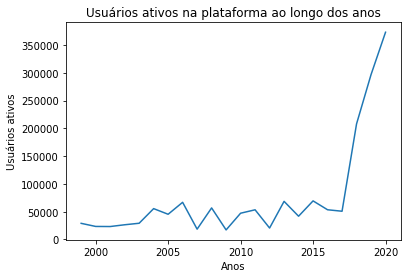

In [44]:
plt.plot(anos, users)
 
plt.xlabel('Anos')
plt.ylabel('Usuários ativos')
plt.title('Usuários ativos na plataforma ao longo dos anos')
plt.show()

Analisar perfil dos usuários. É mais comum termos usuários que sempre estão avaliando ou usuários que aparecem esporadicamente?

Para melhorar a análise, vamos agrupar todos os usuários da plataforma que estavam presentes desde determinado ano. A partir disso, vamos listar em quantos anos posteriores o usuário esteve presente (quanto maior o número, mais presente ele seria). Vamos mudar o objetivo da questão para ver se um usuário se mantém utilizando a plataforma ou se isso se torna raro. Por exemplo. um usuário já estava inscrito na plataforma em 2015. Então, analisamos os 5 anos posteriores e avaliamos a sua atividade no site.

In [45]:
df2 = df2.groupBy("reviewer").count()

In [46]:
us = df2.select(col("reviewer")).toPandas().values
atividade = df2.select(col("count")).toPandas().values

In [47]:
username = []
activity = []

for i in range(len(us)):
    a = i
    b = int(atividade[i])
    username.append(a)
    activity.append(b) 

In [48]:
import pandas as pd

new_df = pd.DataFrame(list(zip(username, activity)),columns=['user_id', 'activity'])

<AxesSubplot:xlabel='user_id', ylabel='activity'>

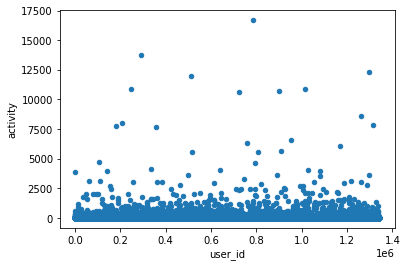

In [49]:
new_df.plot.scatter(x='user_id', y='activity') 

In [75]:
df3 = df_spark.select(col("movie"),col("reviewer"),col("review_date"))

In [76]:
df3 = df3.withColumn('ano', regexp_extract("review_date", "(\\d{4})" , 1))

In [77]:
df3 = df3.withColumn('n_digitos', F.length('ano'))

In [78]:
df3 = df3.filter(df3.n_digitos == '4')

In [79]:
from pyspark.sql.functions import when
from pyspark.sql.functions import lit

In [80]:
df3 = df3.withColumn("2015", when((df3.ano == "2015"), lit(1)).otherwise(lit(0)))

In [81]:
df3 = df3.withColumn("2016", when((df3.ano == "2016"), lit(1)).otherwise(lit(0)))

In [82]:
df3 = df3.withColumn("2017", when((df3.ano == "2017"), lit(1)).otherwise(lit(0)))

In [83]:
df3 = df3.withColumn("2018", when((df3.ano == "2018"), lit(1)).otherwise(lit(0)))

In [84]:
df3 = df3.withColumn("2019", when((df3.ano == "2019"), lit(1)).otherwise(lit(0)))

In [85]:
df3 = df3.withColumn("2020", when((df3.ano == "2020"), lit(1)).otherwise(lit(0)))

In [86]:
df3 = df3.filter(df3.ano >= 2015)

In [87]:
df3 = df3.groupBy("reviewer").sum("2015","2016","2017","2018","2019","2020")

In [88]:
df3 = df3.withColumn("sum(2015)", when(df3['sum(2015)'] > 1, 1))
df3 = df3.withColumn("sum(2016)", when(df3['sum(2016)'] > 1, 1))
df3 = df3.withColumn("sum(2017)", when(df3['sum(2017)'] > 1, 1))
df3 = df3.withColumn("sum(2018)", when(df3['sum(2018)'] > 1, 1))
df3 = df3.withColumn("sum(2019)", when(df3['sum(2019)'] > 1, 1))
df3 = df3.withColumn("sum(2020)", when(df3['sum(2020)'] > 1, 1))

In [89]:
df3 = df3.withColumn("atividade", df3["sum(2015)"]+df3["sum(2016)"]+df3["sum(2017)"]+df3["sum(2018)"]+df3["sum(2019)"]+df3["sum(2020)"])

In [90]:
df3.groupBy("atividade").count().show()

+---------+------+
|atividade| count|
+---------+------+
|     null|881532|
|        6|   795|
+---------+------+



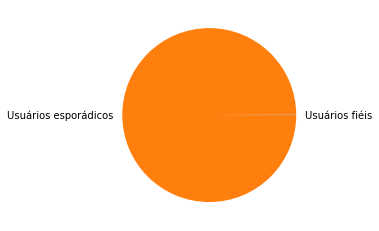

In [91]:
grupos = ['Usuários fiéis', 'Usuários esporádicos']
atv = [795, 881532]

plt.pie(atv, labels=grupos)
plt.show()

Analisar se um filme envelheceu bem - reviews ficam mais positivas ao longo do tempo?

In [92]:
df4 = df_spark.select(col("movie"), col("rating"), col("review_date"))

In [93]:
df4 = df4.withColumn('ano', regexp_extract("review_date", "(\\d{4})" , 1))
df4 = df4.withColumn("rating", df4["rating"].cast(IntegerType()))
df4 = df4.withColumn('n_digitos', F.length('ano'))
df4 = df4.filter(df4.n_digitos == '4')

In [95]:
m1 = df4.filter(df4.movie == 'Batman (1989)')
m2 = df4.filter(df4.movie == 'Ghostbusters (1984)')
m3 = df4.filter(df4.movie == 'Star Trek II: The Wrath of Khan (1982)')
m4 = df4.filter(df4.movie == 'The Goonies (1985)')
m5 = df4.filter(df4.movie == 'Gremlins (1984)')
m6 = df4.filter(df4.movie == 'Aliens (1986)')
m7 = df4.filter(df4.movie == 'Indiana Jones and the Raiders of the Lost Ark (1981)')
m8 = df4.filter(df4.movie == 'E.T. the Extra-Terrestrial (1982)')
m9 = df4.filter(df4.movie == 'Back to the Future (1985)')
m10 = df4.filter(df4.movie == 'Star Wars: Episode V - The Empire Strikes Back (1980)')

In [96]:
m1 = m1.groupBy("ano").mean('rating')
m2 = m2.groupBy("ano").mean('rating')
m3 = m3.groupBy("ano").mean('rating')
m4 = m4.groupBy("ano").mean('rating')
m5 = m5.groupBy("ano").mean('rating')
m6 = m6.groupBy("ano").mean('rating')
m7 = m7.groupBy("ano").mean('rating')
m8 = m8.groupBy("ano").mean('rating')
m9 = m9.groupBy("ano").mean('rating')
m10 = m10.groupBy("ano").mean('rating')

In [97]:
m1 = m1.orderBy(col("ano").desc())
m2 = m2.orderBy(col("ano").desc())
m3 = m3.orderBy(col("ano").desc())
m4 = m4.orderBy(col("ano").desc())
m5 = m5.orderBy(col("ano").desc())
m6 = m6.orderBy(col("ano").desc())
m7 = m7.orderBy(col("ano").desc())
m8 = m8.orderBy(col("ano").desc())
m9 = m9.orderBy(col("ano").desc())
m10 = m10.orderBy(col("ano").desc())

In [123]:
m1n = [9.0, 8.39, 8.27, 9.0, 7.37, 8.75, 8.44, 8.19, 7.47, 8.0, 7.88, 7.26, 7.54, 8.14, 7.47, 8.03]

In [125]:
m2n = [8.0, 9.33, 9.16, 8.18, 9.0, 7.93, 7.85, 7.42, 8.16, 8.08, 7.38, 7.5, 8.5, 7.67, 7.62, 7.66]
#2009 tá nulo

In [111]:
m3n = [10.0, 7.33, 8.3, 9.14, 8.26, 10.0, 8.2, 8.0, 7.7, 6.33, 9.0, 8.4, 8.0, 8.5, 8.93, 8.15]

In [119]:
m4n = [10.0, 8.75, 7.92, 9.0, 7.18, 5.25, 8.11, 6.6, 8.28, 7.5, 8.71, 7.8, 7.55, 8.16, 7.30, 7.0]

In [113]:
m5n = [10.0, 7.8, 7.71, 8.0, 9.16, 7.0, 7.71, 8.0, 7.33, 7.75, 7.37, 6.8, 7.72, 8.07, 7.84, 7.60]

In [114]:
m6n = [9.33, 8.7, 9.04, 9.5, 8.8, 8.16, 8.65, 8.05, 8.86, 9.0, 8.77, 8.84, 8.25, 8.61, 8.19, 8.63]

In [104]:
m7n = [9.07, 9.16, 10.0, 9.05, 9.37, 8.8, 9.0, 8.44, 8.83, 7.66]

[Stage 72:===========================================>              (3 + 1) / 4]

+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2019|7.666666666666667|
|2016|8.833333333333334|
|2014|8.444444444444445|
|2011|              9.0|
|2010|              8.8|
|2009|            9.375|
|2008| 9.05084745762712|
|2007|             10.0|
|2006|9.166666666666666|
|2005|9.076923076923077|
+----+-----------------+



In [115]:
m8n = [9.2, 8.71, 8.37, 4.0, 8.38, 7.0, 8.07, 8.4, 7.95, 8.28, 8.42, 7.8, 8.22, 8.90, 8.04, 8.31]

In [131]:
m9n = [9.37, 9.48, 9.68, 9.75, 10.0, 10.0, 9.5, 9.44, 8.95, 9.27, 9.3, 9.3, 9.53, 8.9, 8.94, 8.9]

In [117]:
m10n = [9.33, 9.8, 8.9, 9.4, 8.91, 9.37, 9.24, 9.75, 9.53, 8.21, 9.28, 9.25, 9.34, 9.22, 8.87, 9.0]
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

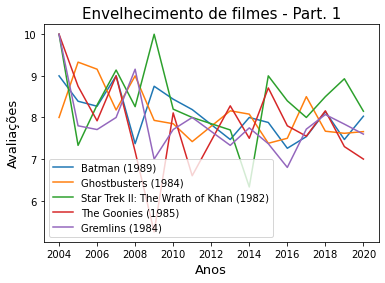

In [129]:
plt.plot(years,m1n,label="Batman (1989)")
plt.plot(years,m2n,label="Ghostbusters (1984)")
plt.plot(years,m3n,label="Star Trek II: The Wrath of Khan (1982)")
plt.plot(years,m4n,label="The Goonies (1985)")
plt.plot(years, m5n, label="Gremlins (1984)")

plt.title("Envelhecimento de filmes - Part. 1", fontsize=15)
plt.xlabel("Anos",fontsize=13)
plt.ylabel("Avaliações",fontsize=13)
plt.legend()
plt.show()

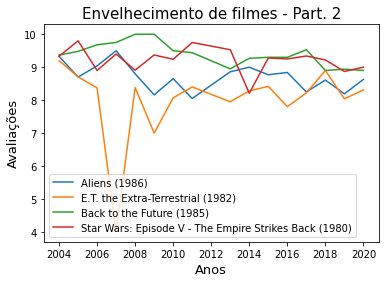

In [132]:
plt.plot(years,m6n,label="Aliens (1986)")
plt.plot(years,m8n,label="E.T. the Extra-Terrestrial (1982)")
plt.plot(years,m9n,label="Back to the Future (1985)")
plt.plot(years,m10n,label="Star Wars: Episode V - The Empire Strikes Back (1980)")

plt.title("Envelhecimento de filmes - Part. 2", fontsize=15)
plt.xlabel("Anos",fontsize=13)
plt.ylabel("Avaliações",fontsize=13)
plt.legend()
plt.show()

As top-reviews impactaram nas notas futuras dos 3 filmes mais populares da plataforma?
- Como top-reviews, vamos considerar aquela com o melhor resultado na relação helpful/helpful+não helpful
- Vamos dividir os dados em 2 grupos: antes da top-review, depois da top-review
- Vamos tirar a média dos dois grupos; para o grupo do depois, vamos tirar a média para cada ano após a review
- Vamos selecionar os 3 filmes mais populares da plataforma e realizar a análise sobre eles.

In [6]:
df5 = df_spark.select(col("helpful"),col("rating"),col("review_date"),col("movie"))
df5 = df5.dropna()

In [9]:
df5 = df5.withColumn('ano', regexp_extract("review_date", "(\\d{4})" , 1))

In [15]:
df5 = df5.withColumn("rating", df5["rating"].cast(IntegerType()))
df5 = df5.withColumn('n_digitos', F.length('ano'))
df5 = df5.filter(df5.n_digitos == '4')

In [145]:
df5.show()

[Stage 81:>                                                         (0 + 1) / 1]

+--------+------+-----------------+--------------------+----+---------+
| helpful|rating|      review_date|               movie| ano|n_digitos|
+--------+------+-----------------+--------------------+----+---------+
|  [1, 3]|    10| 13 December 2001|Dead Man on Campu...|2001|        4|
|  [1, 3]|     8|    11 March 1999|Dead Man on Campu...|1999|        4|
|  [1, 3]|    10|     26 July 2002|Dead Man on Campu...|2002|        4|
|  [1, 3]|     9|  20 January 2003|Dead Man on Campu...|2003|        4|
|  [1, 3]|     9|  8 February 2003|Dead Man on Campu...|2003|        4|
|  [4, 8]|     5|     1 April 2003|Dead Man on Campu...|2003|        4|
|  [5, 7]|     4|11 September 2003|Dead Man on Campu...|2003|        4|
|  [2, 5]|     5|  9 December 2003|Dead Man on Campu...|2003|        4|
|[27, 36]|    10|      30 May 2004|Dead Man on Campu...|2004|        4|
|  [1, 6]|    10| 14 February 2003|Dharma & Greg (19...|2003|        4|
|  [2, 6]|     8|  30 January 2004|Dharma & Greg (19...|2004|   

In [16]:
util = df5.select(col("helpful")).toPandas().values

In [17]:
new_util = []

for i in range(len(util)):
    #print(util[i])
    for j in util[i]:
        if(j[1] == '0'):
            utilidade = 0
        else:
            if "," in j[0]:
                j[0] = j[0].replace(",", "")
            if "," in j[1]:
                j[1] = j[1].replace(",", "")
            
            utilidade = int(j[0])/int(j[1])
        new_util.append(utilidade)

In [192]:
new_util        

[0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.5,
 0.7142857142857143,
 0.4,
 0.75,
 0.16666666666666666,
 0.3333333333333333,
 0.42857142857142855,
 0.8533333333333334,
 0.926829268292683,
 0.2857142857142857,
 0.896551724137931,
 0.5,
 0.9130434782608695,
 1.0,
 0.5,
 1.0,
 1.0,
 0.1111111111111111,
 0.5555555555555556,
 0.6666666666666666,
 0.5,
 0.6,
 0.6,
 0.09090909090909091,
 0.75,
 0.6666666666666666,
 0.125,
 0.75,
 0.6666666666666666,
 0.6153846153846154,
 0.6666666666666666,
 0.5714285714285714,
 0.5,
 0.6428571428571429,
 0.5555555555555556,
 0.625,
 0.6923076923076923,
 0.9,
 0.6744186046511628,
 0.75,
 0.7727272727272727,
 0.9375,
 1.0,
 0.6666666666666666,
 0.25,
 0.0,
 0.6666666666666666,
 0.5,
 0.25,
 0.4,
 0.8,
 0.9,
 0.8571428571428571,
 1.0,
 0.8888888888888888,
 0.9436619718309859,
 0.7777777777777778,
 0.6153846153846154,
 0.14285714285714285,
 0.7857142857142857,
 0.0,
 0.9,
 0.6666666666666666,
 0.3,
 

In [18]:
df6 = df5.toPandas()

In [19]:
df6["utilidade"] = new_util

In [20]:
df7 = spark.createDataFrame(df6)

In [21]:
df7 = df7.withColumn('lancamento', regexp_extract(col('movie'),  r"\(([^()]+)\)$", 1))

In [215]:
#pegar filmes mais populares que foram lançados antes de 2015
#analisar uma top-review de 2015
#ver tendencias de notas nos 5 anos seguintes até 2020

filmespopulares = df7.filter(df7.lancamento < 2015)
filmespopulares.show()

2022-02-20 11:01:46,075 WARN scheduler.TaskSetManager: Stage 100 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+--------+------+-----------------+--------------------+----+---------+-------------------+----------+
| helpful|rating|      review_date|               movie| ano|n_digitos|          utilidade|lancamento|
+--------+------+-----------------+--------------------+----+---------+-------------------+----------+
|  [1, 3]|    10| 13 December 2001|Dead Man on Campu...|2001|        4| 0.3333333333333333|      1998|
|  [1, 3]|     8|    11 March 1999|Dead Man on Campu...|1999|        4| 0.3333333333333333|      1998|
|  [1, 3]|    10|     26 July 2002|Dead Man on Campu...|2002|        4| 0.3333333333333333|      1998|
|  [1, 3]|     9|  20 January 2003|Dead Man on Campu...|2003|        4| 0.3333333333333333|      1998|
|  [1, 3]|     9|  8 February 2003|Dead Man on Campu...|2003|        4| 0.3333333333333333|      1998|
|  [4, 8]|     5|     1 April 2003|Dead Man on Campu...|2003|        4|                0.5|      1998|
|  [5, 7]|     4|11 September 2003|Dead Man on Campu...|2003|        4| 0

In [216]:
filmespopulares = filmespopulares.groupBy("movie").count()
filmespopulares.show()

2022-02-20 11:02:04,607 WARN scheduler.TaskSetManager: Stage 101 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.
[Stage 101:===================================>                     (5 + 3) / 8]

+--------------------+-----+
|               movie|count|
+--------------------+-----+
| The Last Don (1997)|   17|
|And Now Tomorrow ...|   13|
|       Thirst (2009)|   35|
|   Annie Hall (1977)|  238|
|       Agency (1980)|   11|
|22 Jump Street (2...|  195|
|Before Night Fall...|   19|
|        Birth (2004)|  175|
|Abre los ojos (1997)|   14|
|       Psycho (1960)|  883|
|The Parallax View...|   61|
|     Bastards (2013)|   13|
|I Love You Philli...|  144|
|Beauty and the Bo...|   17|
|Good Vibrations (...|   19|
|     勇者無懼 (1997)|    3|
|Night of the Livi...|  232|
|El niño de barro ...|    2|
|Heavenly Creature...|  168|
|Videogramme einer...|    2|
+--------------------+-----+
only showing top 20 rows



In [217]:
filmespopulares = filmespopulares.orderBy(col("count").desc())
filmespopulares.show()

2022-02-20 11:02:17,982 WARN scheduler.TaskSetManager: Stage 103 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.
[Stage 103:=================================================>       (7 + 1) / 8]

+--------------------+-----+
|               movie|count|
+--------------------+-----+
|The Shawshank Red...| 6715|
|The Dark Knight (...| 6041|
|The Lord of the R...| 4377|
|    Inception (2010)| 3593|
|   The Matrix (1999)| 3196|
|The Lord of the R...| 2967|
|   Fight Club (1999)| 2773|
|Star Wars: Episod...| 2719|
|Star Wars: Episod...| 2717|
|The Godfather (1972)| 2603|
| Man of Steel (2013)| 2538|
| Interstellar (2014)| 2308|
|Star Wars: Episod...| 2203|
| Pulp Fiction (1994)| 2173|
|Indiana Jones and...| 1950|
|The Lord of the R...| 1933|
|      Gravity (2013)| 1914|
|Casino Royale (2006)| 1873|
| Forrest Gump (1994)| 1862|
|The Passion of th...| 1829|
+--------------------+-----+
only showing top 20 rows



In [22]:
f1 = df7.filter(df7.movie == 'The Shawshank Redemption (1994)')
f2 = df7.filter(df7.movie == 'The Dark Knight (2008)')
f3 = df7.filter(df7.movie == 'The Lord of the Rings: The Fellowship of the Ring (2001)')
f4 = df7.filter(df7.movie == 'Inception (2010)')
f5 = df7.filter(df7.movie == 'The Matrix (1999)')

In [34]:
f1.groupBy("ano", "rating").max("utilidade").show()

2022-02-20 22:28:30,392 WARN scheduler.TaskSetManager: Stage 107 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+------+-------------------+
| ano|rating|     max(utilidade)|
+----+------+-------------------+
|2015|     7|                0.0|
|2002|     9|                0.0|
|2010|     7|               0.75|
|2019|     2|                0.2|
|1999|     7| 0.6666666666666666|
|2002|     1|0.27906976744186046|
|2010|     4|0.16666666666666666|
|2006|     2|0.26666666666666666|
|2002|     6|0.42857142857142855|
|2003|     2| 0.2857142857142857|
|2020|     8|                1.0|
|2019|     3| 0.3333333333333333|
|2014|     1|0.23622047244094488|
|2006|     6|                0.0|
|2010|     1| 0.1885245901639344|
|2021|    10|                1.0|
|1998|    10|                1.0|
|2016|     7| 0.3333333333333333|
|2003|     5|0.42424242424242425|
|2001|     8| 0.7221385542168675|
+----+------+-------------------+
only showing top 20 rows



In [24]:
f1.groupBy("ano").mean("rating").show()

2022-02-20 22:13:47,991 WARN scheduler.TaskSetManager: Stage 11 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016|9.403448275862068|
|2020|9.366528354080222|
|2019|9.244916820702404|
|2017|9.418439716312056|
|2014|9.406976744186046|
|2013|9.452513966480447|
|2005|9.368421052631579|
|2000|9.325301204819278|
|2002| 9.06989247311828|
|2018|9.389662027833001|
|2009|              9.0|
|2006|8.848101265822784|
|2004|9.072368421052632|
|2011| 9.23157894736842|
|2008| 9.20388349514563|
|1999|9.154639175257731|
|2007|9.263157894736842|
|2021|          9.46875|
|2015|9.366666666666667|
|1998|9.568181818181818|
+----+-----------------+
only showing top 20 rows



In [37]:
import math

#coeficiente de correlação pearson
def pearson(x, y):
    media1 = sum(x)/len(x)
    media2 = sum(x)/len(x)
    
    soma1 = 0
    soma2 = 0
    soma3 = 0
    
    for i in range(len(x)):
        soma1 = soma1+((x[i]-media1)*(y[i]-media2))
        soma2 = soma2+((x[i]-media1)**2)
        soma3 = soma3+((x[i]-media1)**2)
        
    fator1 = soma1
    fator2 = soma2*soma3
    fator3 = math.sqrt(fator2)
    
    return (fator1/fator3)

In [38]:
n11 = [10,7,8,6,5,2,7,1,7,7,3,8]
n12 = [9,56,9.15,9.32,9.06,9.06,8.84,9.0,9.40,9.36,9.40,9.24,9.36]
print(pearson(n11,n12))

0.6456071805702215


In [221]:
#pega top-review
f1.orderBy(col("ano").asc(),col("utilidade").desc()).show(truncate=False)

2022-02-20 11:10:26,472 WARN scheduler.TaskSetManager: Stage 106 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.
[Stage 106:============================>                            (4 + 4) / 8]

+----------+------+-----------------+-------------------------------+----+---------+------------------+----------+
|helpful   |rating|review_date      |movie                          |ano |n_digitos|utilidade         |lancamento|
+----------+------+-----------------+-------------------------------+----+---------+------------------+----------+
|[1, 1]    |7     |2 November 1998  |The Shawshank Redemption (1994)|1998|4        |1.0               |1994      |
|[1, 1]    |10    |3 October 1998   |The Shawshank Redemption (1994)|1998|4        |1.0               |1994      |
|[108, 128]|10    |21 October 1998  |The Shawshank Redemption (1994)|1998|4        |0.84375           |1994      |
|[6, 8]    |10    |6 November 1998  |The Shawshank Redemption (1994)|1998|4        |0.75              |1994      |
|[5, 7]    |10    |24 December 1998 |The Shawshank Redemption (1994)|1998|4        |0.7142857142857143|1994      |
|[50, 72]  |10    |2 August 1998    |The Shawshank Redemption (1994)|1998|4     

In [222]:
f2.orderBy(col("ano").asc(),col("utilidade").desc()).show(truncate=False)

2022-02-20 11:12:59,161 WARN scheduler.TaskSetManager: Stage 107 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.
[Stage 107:==============>                                          (2 + 6) / 8]

+--------------+------+-----------------+----------------------+----+---------+------------------+----------+
|helpful       |rating|review_date      |movie                 |ano |n_digitos|utilidade         |lancamento|
+--------------+------+-----------------+----------------------+----+---------+------------------+----------+
|[873, 1,072]  |10    |20 July 2008     |The Dark Knight (2008)|2008|4        |0.8143656716417911|2008      |
|[3,854, 4,899]|10    |9 July 2008      |The Dark Knight (2008)|2008|4        |0.7866911614615227|2008      |
|[583, 748]    |10    |20 July 2008     |The Dark Knight (2008)|2008|4        |0.7794117647058824|2008      |
|[414, 560]    |9     |24 July 2008     |The Dark Knight (2008)|2008|4        |0.7392857142857143|2008      |
|[2,418, 3,467]|10    |7 July 2008      |The Dark Knight (2008)|2008|4        |0.6974329391404672|2008      |
|[219, 317]    |10    |16 July 2008     |The Dark Knight (2008)|2008|4        |0.6908517350157729|2008      |
|[1,383, 2

In [25]:
f2.groupBy("ano", "rating").max("utilidade").show()

2022-02-20 22:17:40,175 WARN scheduler.TaskSetManager: Stage 23 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+------+-------------------+
| ano|rating|     max(utilidade)|
+----+------+-------------------+
|2015|     7|                1.0|
|2019|     2|0.23529411764705882|
|2010|     7| 0.5714285714285714|
|2013|     4|               0.25|
|2010|     4| 0.5555555555555556|
|2020|     8|                1.0|
|2014|     1|                0.5|
|2019|     3| 0.3333333333333333|
|2021|    10|                1.0|
|2010|     1|                0.5|
|2016|     7|                0.0|
|2021|     1|                0.0|
|2017|     3| 0.6666666666666666|
|2008|     3| 0.5555555555555556|
|2014|     8| 0.3333333333333333|
|2014|     6| 0.3333333333333333|
|2018|     8|                1.0|
|2015|     9|               0.75|
|2010|     5| 0.4444444444444444|
|2008|     6|                0.6|
+----+------+-------------------+
only showing top 20 rows



In [26]:
f2.groupBy("ano").mean("rating").show()

2022-02-20 22:17:47,394 WARN scheduler.TaskSetManager: Stage 31 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016| 9.04739336492891|
|2020|9.161629434954008|
|2019| 9.21294964028777|
|2017|9.147058823529411|
|2014|             9.25|
|2013|9.190871369294605|
|2009|6.941935483870968|
|2018|9.301587301587302|
|2011|8.333333333333334|
|2008|8.268158617981939|
|2021|8.782608695652174|
|2015| 9.06159420289855|
|2010| 8.30232558139535|
+----+-----------------+



In [39]:
n21 = [8,7,4,1,7,7,3,8,3,8]
n22 = [8.26,8.30,9.19,9.25,9.06,9.04,9.14,9.39,9.21,9.16]
print(pearson(n21,n22))

-0.060596026490066


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 51758)
Traceback (most recent call last):
  File "/usr/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.7/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.7/socketserver.py", line 720, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/opt/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/opt/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/opt/spark/python/pyspark/serializers.py", line 724, in read_int
    r

In [223]:
f3.orderBy(col("ano").asc(),col("utilidade").desc()).show(truncate=False)

2022-02-20 11:14:24,369 WARN scheduler.TaskSetManager: Stage 108 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.
[Stage 108:==========================================>              (6 + 2) / 8]

+-------+------+----------------+--------------------------------------------------------+----+---------+---------+----------+
|helpful|rating|review_date     |movie                                                   |ano |n_digitos|utilidade|lancamento|
+-------+------+----------------+--------------------------------------------------------+----+---------+---------+----------+
|[1, 1] |10    |11 December 2001|The Lord of the Rings: The Fellowship of the Ring (2001)|2001|4        |1.0      |2001      |
|[1, 1] |10    |9 December 2001 |The Lord of the Rings: The Fellowship of the Ring (2001)|2001|4        |1.0      |2001      |
|[1, 1] |10    |18 December 2001|The Lord of the Rings: The Fellowship of the Ring (2001)|2001|4        |1.0      |2001      |
|[1, 1] |10    |21 December 2001|The Lord of the Rings: The Fellowship of the Ring (2001)|2001|4        |1.0      |2001      |
|[1, 1] |10    |18 December 2001|The Lord of the Rings: The Fellowship of the Ring (2001)|2001|4        |1.0   

In [27]:
f3.groupBy("ano", "rating").max("utilidade").show()

2022-02-20 22:17:55,215 WARN scheduler.TaskSetManager: Stage 41 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.
[Stage 41:===========================================>              (6 + 2) / 8]

+----+------+-------------------+
| ano|rating|     max(utilidade)|
+----+------+-------------------+
|2015|     7|                0.0|
|2002|     9|                1.0|
|2010|     7|                0.0|
|2007|     1|0.05263157894736842|
|2002|     1|                0.5|
|2006|     2|                0.0|
|2002|     6|               0.75|
|2003|     2| 0.6666666666666666|
|2020|     8|                1.0|
|2014|     1|                0.5|
|2019|     3|0.11764705882352941|
|2006|     6|                0.5|
|2021|    10|                0.0|
|2010|     1| 0.4117647058823529|
|2016|     7|                0.0|
|2021|     1|                0.0|
|2003|     5|                0.5|
|2008|     3| 0.3333333333333333|
|2001|     8|                0.0|
|2014|     8|                0.0|
+----+------+-------------------+
only showing top 20 rows



In [28]:
f3.groupBy("ano").mean("rating").show()

2022-02-20 22:18:02,672 WARN scheduler.TaskSetManager: Stage 47 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016|9.472222222222221|
|2020|8.895454545454545|
|2019|8.723577235772357|
|2017|8.523809523809524|
|2014|8.777777777777779|
|2013|9.142857142857142|
|2005|8.132075471698114|
|2002|  8.2932944606414|
|2018|           8.7625|
|2009|            9.375|
|2006|7.153846153846154|
|2004|8.226415094339623|
|2011|8.774193548387096|
|2008|8.088888888888889|
|2007|8.153846153846153|
|2021|              7.0|
|2015|              8.5|
|2001|8.843110504774897|
|2010| 8.80952380952381|
|2003|7.940520446096654|
+----+-----------------+



In [40]:
n31 = [8,9,2,6,1,3,1,1,7,7,8]
n32 = [8.84,8.29,7.94,7.15,8.15,8.08,8.80,8.77,8.5,9.47,8.89]
print(pearson(n31,n32))

0.03345614035087705


In [224]:
f4.orderBy(col("ano").asc(),col("utilidade").desc()).show(truncate=False)

2022-02-20 11:15:49,304 WARN scheduler.TaskSetManager: Stage 109 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.
[Stage 109:==========================================>              (6 + 2) / 8]

+--------------+------+-----------------+----------------+----+---------+------------------+----------+
|helpful       |rating|review_date      |movie           |ano |n_digitos|utilidade         |lancamento|
+--------------+------+-----------------+----------------+----+---------+------------------+----------+
|[4, 4]        |7     |6 October 2010   |Inception (2010)|2010|4        |1.0               |2010      |
|[16, 16]      |10    |2 August 2010    |Inception (2010)|2010|4        |1.0               |2010      |
|[26, 27]      |9     |1 August 2010    |Inception (2010)|2010|4        |0.9629629629629629|2010      |
|[18, 19]      |9     |4 August 2010    |Inception (2010)|2010|4        |0.9473684210526315|2010      |
|[10, 11]      |10    |4 August 2010    |Inception (2010)|2010|4        |0.9090909090909091|2010      |
|[14, 16]      |10    |2 August 2010    |Inception (2010)|2010|4        |0.875             |2010      |
|[7, 8]        |10    |25 July 2010     |Inception (2010)|2010|4

In [29]:
f4.groupBy("ano", "rating").max("utilidade").show()

2022-02-20 22:18:10,293 WARN scheduler.TaskSetManager: Stage 57 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+------+-------------------+
| ano|rating|     max(utilidade)|
+----+------+-------------------+
|2015|     7|                0.5|
|2010|     7|                1.0|
|2019|     2|0.16666666666666666|
|2013|     4|                1.0|
|2010|     4| 0.7142857142857143|
|2020|     8|                1.0|
|2019|     3| 0.3333333333333333|
|2014|     1|                0.8|
|2010|     1| 0.6428571428571429|
|2021|    10|                0.0|
|2016|     7|                0.0|
|2014|     8| 0.6666666666666666|
|2014|     6|                0.0|
|2018|     8|                0.5|
|2015|     9| 0.6666666666666666|
|2010|     5|               0.75|
|2011|     9|                1.0|
|2013|     6|                1.0|
|2013|     7|                0.5|
|2015|     2|                1.0|
+----+------+-------------------+
only showing top 20 rows



In [30]:
f4.groupBy("ano").mean("rating").show()

2022-02-20 22:18:17,055 WARN scheduler.TaskSetManager: Stage 65 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016|8.666666666666666|
|2020|8.783094098883572|
|2019|8.838582677165354|
|2017|              9.0|
|2014|8.578947368421053|
|2013|8.459016393442623|
|2018| 8.71923076923077|
|2011|6.836923076923077|
|2021|9.666666666666666|
|2015|8.847826086956522|
|2010|7.613242574257426|
+----+-----------------+



In [41]:
n41 = [7,9,6,1,2,7,8,3,8]
n42 = [7.61,6.83,8.45,8.57,8.84,8.66,8.71,8.83,8.78]
print(pearson(n41,n42))

-0.11568627450980401


In [225]:
f5.orderBy(col("ano").asc(),col("utilidade").desc()).show(truncate=False)

2022-02-20 11:17:05,479 WARN scheduler.TaskSetManager: Stage 110 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.
[Stage 110:============================>                            (4 + 4) / 8]

+----------+------+---------------+-----------------+----+---------+------------------+----------+
|helpful   |rating|review_date    |movie            |ano |n_digitos|utilidade         |lancamento|
+----------+------+---------------+-----------------+----+---------+------------------+----------+
|[1, 1]    |10    |8 April 1999   |The Matrix (1999)|1999|4        |1.0               |1999      |
|[1, 1]    |10    |13 June 1999   |The Matrix (1999)|1999|4        |1.0               |1999      |
|[1, 1]    |8     |29 March 1999  |The Matrix (1999)|1999|4        |1.0               |1999      |
|[1, 1]    |10    |4 April 1999   |The Matrix (1999)|1999|4        |1.0               |1999      |
|[1, 1]    |10    |23 July 1999   |The Matrix (1999)|1999|4        |1.0               |1999      |
|[1, 1]    |10    |6 April 1999   |The Matrix (1999)|1999|4        |1.0               |1999      |
|[1, 1]    |9     |19 April 1999  |The Matrix (1999)|1999|4        |1.0               |1999      |
|[1, 1]   

In [31]:
f5.groupBy("ano", "rating").max("utilidade").show()

2022-02-20 22:18:24,513 WARN scheduler.TaskSetManager: Stage 75 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+------+-------------------+
| ano|rating|     max(utilidade)|
+----+------+-------------------+
|2015|     7| 0.6666666666666666|
|2002|     9|                0.5|
|2010|     7| 0.3333333333333333|
|1999|     7|                1.0|
|2002|     1| 0.4230769230769231|
|2006|     2| 0.4166666666666667|
|2002|     6|                0.5|
|2003|     2|0.45454545454545453|
|2020|     8|                1.0|
|2019|     3|0.16666666666666666|
|2006|     6|                0.0|
|2021|    10|                1.0|
|2016|     7| 0.5909090909090909|
|2003|     5| 0.3333333333333333|
|2001|     8|                0.5|
|2008|     3|0.42857142857142855|
|2014|     8|                0.5|
|2018|     8|                1.0|
|1999|     1| 0.4166666666666667|
|2002|     7|                0.5|
+----+------+-------------------+
only showing top 20 rows



In [32]:
f5.groupBy("ano").mean("rating").show()

2022-02-20 22:18:31,885 WARN scheduler.TaskSetManager: Stage 83 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016|8.823529411764707|
|2020|8.696969696969697|
|2019|9.005681818181818|
|2017|8.511627906976743|
|2014|9.325581395348838|
|2013|9.065573770491802|
|2005|8.076923076923077|
|2000|8.068852459016393|
|2002|7.982456140350878|
|2018|8.899441340782124|
|2009|7.583333333333333|
|2006|              8.0|
|2004| 7.52112676056338|
|2011|8.678571428571429|
|2008| 8.64102564102564|
|1999|8.616666666666667|
|2007|              9.8|
|2021|9.157894736842104|
|2015|8.714285714285714|
|2001|7.933333333333334|
+----+-----------------+
only showing top 20 rows



In [43]:
n51 = [7,8,9,2,2,3,7,8,7,8,3,8]
n52 = [8.61,7.93,7.98,7.98,8.0,7.58,9.32,8.71,8.89,9.0,8.69,8.3]
print(pearson(n51,n52))

0.07576923076923081


In [227]:
#pega reviews depois da top-review
df1 = f1.filter(f1.ano > 1998)
df2 = f2.filter(f2.ano > 2008)
df3 = f3.filter(f3.ano > 2001)
df4 = f4.filter(f4.ano > 2010)
df5 = f5.filter(f5.ano > 1999)

df1 = df1.withColumn("rating", df1["rating"].cast(IntegerType()))
df2 = df2.withColumn("rating", df2["rating"].cast(IntegerType()))
df3 = df3.withColumn("rating", df3["rating"].cast(IntegerType()))
df4 = df4.withColumn("rating", df4["rating"].cast(IntegerType()))
df5 = df5.withColumn("rating", df5["rating"].cast(IntegerType()))

In [228]:
#tira média das depois 
df1 = df1.groupBy("ano").mean("rating")
df2 = df2.groupBy("ano").mean("rating")
df3 = df3.groupBy("ano").mean("rating")
df4 = df4.groupBy("ano").mean("rating")
df5 = df5.groupBy("ano").mean("rating")

In [229]:
df1.show()

2022-02-20 11:33:28,424 WARN scheduler.TaskSetManager: Stage 111 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016|9.403448275862068|
|2020|9.366528354080222|
|2019|9.244916820702404|
|2017|9.418439716312056|
|2014|9.406976744186046|
|2013|9.452513966480447|
|2005|9.368421052631579|
|2000|9.325301204819278|
|2002| 9.06989247311828|
|2018|9.389662027833001|
|2009|              9.0|
|2006|8.848101265822784|
|2004|9.072368421052632|
|2011| 9.23157894736842|
|2008| 9.20388349514563|
|1999|9.154639175257731|
|2007|9.263157894736842|
|2021|          9.46875|
|2015|9.366666666666667|
|2001|9.388235294117647|
+----+-----------------+
only showing top 20 rows



In [12]:
anos1 = [1999, 2000, 2001, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
notas1 = [9.15, 9.32, 9.38, 9.06, 9.07, 9.36, 8.84, 9.26, 9.20, 9.0, 9.23, 9.45, 9.40, 9.36, 9.40, 9.41, 9.38, 9.24, 9.36, 9.46]
t1 = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10, 10, 10]

In [19]:
print(pearson(notas1, t1))

0.013572250000000891
0.016434500000000473
0.029316749999999704
0.07195900000000122
0.11057125000000274
0.11931350000000185
0.30121575000000556
0.30125800000000563
0.30568025000000626
0.3767025000000085
0.37803475000000875
0.41170700000000693
0.4295292500000059
0.43827150000000503
0.456093750000004
0.47668600000000283
0.48956825000000204
0.4902705000000023
0.4990127500000014
0.5364550000000001


ZeroDivisionError: float division by zero

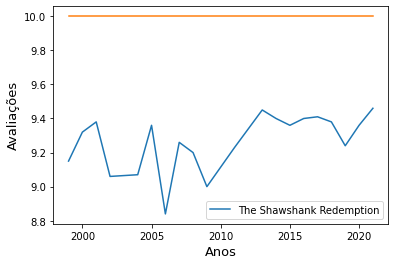

In [237]:
plt.plot(anos1, notas1, label="The Shawshank Redemption")
plt.plot(anos1, t1)

plt.xlabel("Anos",fontsize=13)
plt.ylabel("Avaliações",fontsize=13)
plt.legend()
plt.show()

In [230]:
df2.show()

2022-02-20 11:33:48,534 WARN scheduler.TaskSetManager: Stage 123 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016| 9.04739336492891|
|2020|9.161629434954008|
|2019| 9.21294964028777|
|2017|9.147058823529411|
|2014|             9.25|
|2013|9.190871369294605|
|2018|9.301587301587302|
|2009|6.941935483870968|
|2011|8.333333333333334|
|2021|8.782608695652174|
|2015| 9.06159420289855|
|2010| 8.30232558139535|
+----+-----------------+



In [241]:
anos2 = [2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
notas2 = [6.94, 8.30, 8.33, 9.19, 9.25, 9.06, 9.04, 9.14, 9.30, 9.21, 9.16, 8.78]

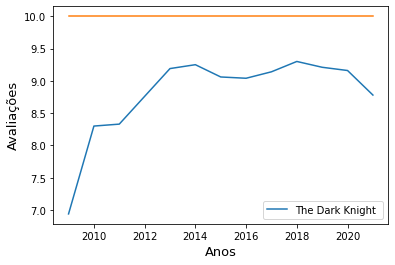

In [243]:
plt.plot(anos2, notas2, label="The Dark Knight ")
t2 = [10,10,10,10,10,10,10,10,10,10,10,10]
plt.plot(anos2, t2)


plt.xlabel("Anos",fontsize=13)
plt.ylabel("Avaliações",fontsize=13)
plt.legend()
plt.show()

In [231]:
df3.show()

2022-02-20 11:34:04,145 WARN scheduler.TaskSetManager: Stage 133 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016|9.472222222222221|
|2020|8.895454545454545|
|2019|8.723577235772357|
|2017|8.523809523809524|
|2014|8.777777777777779|
|2013|9.142857142857142|
|2005|8.132075471698114|
|2002|  8.2932944606414|
|2018|           8.7625|
|2009|            9.375|
|2006|7.153846153846154|
|2004|8.226415094339623|
|2011|8.774193548387096|
|2008|8.088888888888889|
|2007|8.153846153846153|
|2021|              7.0|
|2015|              8.5|
|2010| 8.80952380952381|
|2003|7.940520446096654|
+----+-----------------+



In [244]:
anos3 = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,2021]
notas3 = [8.29,7.94,8.22,8.13,7.15,8.15,8.08,9.37,8.80,8.77,9.14,8.77,8.5,9.47,8.52,8.76,8.72,8.89,7.0]

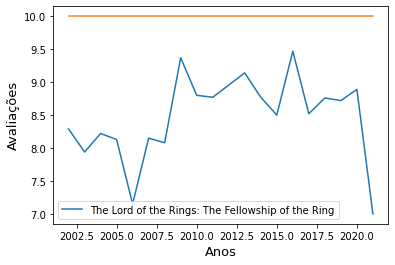

In [246]:
plt.plot(anos3, notas3, label="The Lord of the Rings: The Fellowship of the Ring")
t3 = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]
plt.plot(anos3, t3)


plt.xlabel("Anos",fontsize=13)
plt.ylabel("Avaliações",fontsize=13)
plt.legend()
plt.show()

In [232]:
df4.show()

2022-02-20 11:34:22,575 WARN scheduler.TaskSetManager: Stage 143 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016|8.666666666666666|
|2020|8.783094098883572|
|2019|8.838582677165354|
|2017|              9.0|
|2014|8.578947368421053|
|2013|8.459016393442623|
|2018| 8.71923076923077|
|2011|6.836923076923077|
|2021|9.666666666666666|
|2015|8.847826086956522|
+----+-----------------+



In [247]:
anos4 = [2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
notas4 = [6.83, 8.45, 8.57, 8.84, 8.66, 9.0, 8.71, 8.83, 8.78, 9.66]

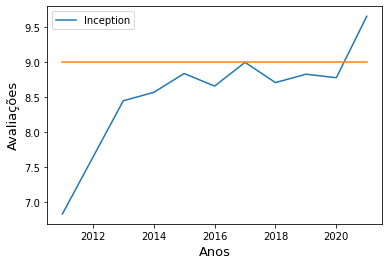

In [249]:
plt.plot(anos4, notas4, label="Inception")
t4 = [9,9,9,9,9,9,9,9,9,9]
plt.plot(anos4, t4)


plt.xlabel("Anos",fontsize=13)
plt.ylabel("Avaliações",fontsize=13)
plt.legend()
plt.show()

In [233]:
df5.show()

2022-02-20 11:34:32,904 WARN scheduler.TaskSetManager: Stage 153 contains a task of very large size (49754 KB). The maximum recommended task size is 100 KB.


+----+-----------------+
| ano|      avg(rating)|
+----+-----------------+
|2016|8.823529411764707|
|2020|8.696969696969697|
|2019|9.005681818181818|
|2017|8.511627906976743|
|2014|9.325581395348838|
|2013|9.065573770491802|
|2005|8.076923076923077|
|2000|8.068852459016393|
|2002|7.982456140350878|
|2018|8.899441340782124|
|2009|7.583333333333333|
|2006|              8.0|
|2004| 7.52112676056338|
|2011|8.678571428571429|
|2008| 8.64102564102564|
|2007|              9.8|
|2021|9.157894736842104|
|2015|8.714285714285714|
|2001|7.933333333333334|
|2010|              9.0|
+----+-----------------+
only showing top 20 rows



In [251]:
anos5 = [2000, 2001, 2002, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
notas5 = [8.06,7.93,7.98,7.52,8.07,8.0,9.8,8.64,7.58,9.0,8.67,9.06,9.32,8.71,8.82,8.51,8.89,9.0,8.69,9.15]

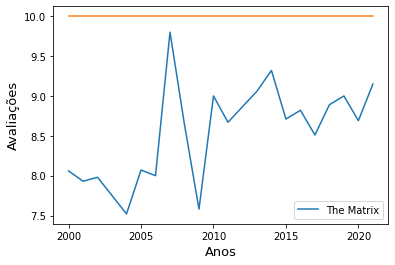

In [253]:
plt.plot(anos5, notas5, label="The Matrix")
t5 = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]
plt.plot(anos5, t5)


plt.xlabel("Anos",fontsize=13)
plt.ylabel("Avaliações",fontsize=13)
plt.legend()
plt.show()

Classificador para prever a nota dos filmes com base nas reviews dos usuários - baseado no conteúdo. Qual a acurácia?

In [30]:
import pyspark.ml.feature
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer

In [61]:
df8 = df_spark.select(col("review_date"),col("review_detail"),col("rating"))
df8 = df8.dropna()

In [62]:
df8 = df8.withColumn('ano', regexp_extract("review_date", "(\\d{4})" , 1))
df8 = df8.withColumn("rating", df8["rating"].cast(IntegerType()))
df8 = df8.withColumn('n_digitos', F.length('ano'))
df8 = df8.filter(df8.n_digitos == '4')

In [63]:
df8 = df8.filter(df8.ano == 2007)

In [64]:
df8 = df8.select(col("review_detail"),col("rating"))

In [65]:
df8.show()

[Stage 12:======================================>                   (2 + 1) / 3]

+--------------------+------+
|       review_detail|rating|
+--------------------+------+
|The setting is pe...|    10|
|"Babel" has recei...|     8|
|Bogie had done fi...|     9|
|I don't know if t...|    10|
|The most recent f...|     5|
|There were actual...|     5|
|Suspenseful, intr...|    10|
|A big surprise, p...|     8|
|it has been at le...|    10|
|Soderbergh is a d...|     7|
|I just read a com...|    10|
|It's a crowd-plea...|     8|
|I'm not really in...|    10|
|Apparently there ...|     5|
|I'm not a film bu...|     8|
|Notes On A Scanda...|    10|
|Few artists span ...|     9|
|I spent many summ...|     9|
|Wow, this movie h...|    10|
|The storyline is ...|     8|
+--------------------+------+
only showing top 20 rows



In [66]:
tokenizer = Tokenizer(inputCol='review_detail',outputCol='mytokens')
stopwords_remover = StopWordsRemover(inputCol='mytokens',outputCol='filtered_tokens')
vectorizer = CountVectorizer(inputCol='filtered_tokens',outputCol='rawFeatures')
idf = IDF(inputCol='rawFeatures',outputCol='vectorizedFeatures')

In [67]:
train, test = df8.randomSplit((0.7,0.3),seed=42)

In [68]:
from pyspark.ml.classification import LogisticRegression

In [69]:
lr = LogisticRegression(featuresCol='vectorizedFeatures', labelCol='rating')

In [71]:
from pyspark.ml import Pipeline 

In [72]:
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf,lr])

In [73]:
lr_model = pipeline.fit(train)

2022-02-21 00:49:04,058 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2022-02-21 00:49:04,059 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [74]:
predictions = lr_model.transform(test)

In [75]:
predictions.show()

[Stage 68:======================================>                   (2 + 1) / 3]

+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|       review_detail|rating|            mytokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|"28 Days Later" i...|     9|["28, days, later...|["28, days, later...|(215507,[1,7,9,10...|(215507,[1,7,9,10...|[-6.8023635802190...|[1.55862066671564...|      10.0|
|"A Classic is som...|    10|["a, classic, is,...|["a, classic, som...|(215507,[0,2,3,4,...|(215507,[0,2,3,4,...|[-6.9177863892700...|[4.99858210958889...|       8.0|
|"A Free Soul" mad...|     6|["a, free, soul",...|["a, free, soul",...|(215507,[3,4,5,7,...|(215507,[3,4,5,7,...|[-6.7709975730557...|[1.62727491165385...|       7.0

In [76]:
predictions = predictions.select(col("rating"),col("prediction"))
predictions.show()

[Stage 70:======================================>                   (2 + 1) / 3]

+------+----------+
|rating|prediction|
+------+----------+
|     9|      10.0|
|    10|       8.0|
|     6|       7.0|
|     7|       2.0|
|     6|       5.0|
|     7|       8.0|
|     7|       9.0|
|     8|      10.0|
|     4|       8.0|
|     6|       8.0|
|    10|       8.0|
|     7|       8.0|
|     2|       1.0|
|    10|      10.0|
|     7|       8.0|
|     8|       9.0|
|     8|       7.0|
|    10|      10.0|
|     9|       7.0|
|    10|       8.0|
+------+----------+
only showing top 20 rows



In [77]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [79]:
evaluator = MulticlassClassificationEvaluator(labelCol='rating',predictionCol='prediction',metricName='accuracy')
acuracia = evaluator.evaluate(predictions)

In [80]:
acuracia

0.31796448087431695